# 2D potential equation

In [1]:
import numpy as np
from numpy.linalg import solve
import matplotlib.pyplot as plt
from time import time

# for sparse matrices
from scipy.sparse import csc_matrix # for sparse matrix
from scipy.sparse.linalg import spsolve # for sparse matrix

from mesh_utils import rectangular_mesh # import everything from custom module mesh_utils

%matplotlib notebook

In [2]:
#################
# USER SETTINGS #
#################

nx = 100; lx = 50 # number of points and length of domain in x direction
ny = 40; ly = 20 # number of points and length of domain in y direction

u_out = 1 # velocity at outflow
u_in = u_out # velocity at inflow

ix_phi = nx - 2 # x-coordinate at which potential is provided
iy_phi = 1 # y-coordinate at which potential is provided
phi_default = 100 # arbitrary value of potential 

Since we already have a class `rectangular_mesh` taking care about the mesh generation, we can just exploit it; however, such class still does not contain information about where inflow and outflow sections are located.

This is fine: such information is specific to this problem - it wouldn't make sense to include it into a class `rectangular_mesh` that is suit for a variety of different problems! However, what could be done is creating a _child class_ of `rectangular_mesh`, meaning a class that _inherits_ everything that is already contained in `rectangular_mesh` - but also adding new content. We will call the children class `potential_mesh`, and it will contain what we now need - meaning, a description of inflow and outflow; we will refer to `rectangular_mesh` as the _parent_ class. This is done by:

In [3]:
class potential_mesh(rectangular_mesh):
    
    #########################################################################
    
    def is_inout(self, ik, boundary):
        # this function returns true if boundary point is an inflow point
        
        inout = '' # initialisation
        
        # inflow/outflow position data
        in_bottom = self.ly/4
        in_top = self.ly/2
        out_bottom = self.ly/2
        out_top = 3*self.ly/4
                
        _, iy = self.get_mat_pos(ik) # get 2d indices of current point
        y_value = self.y[iy] # get y position of current point
        
        # inflow is west, between the given values of y
        if boundary == 'w' and y_value > in_bottom and y_value < in_top:
            inout = 'in'

        # outflow is east, between the given values of y
        if boundary == 'e' and y_value > out_bottom and y_value < out_top:
            inout = 'out'
            
        return inout

Now, class `potential_mesh` contains everything that was in `rectangular mesh`, with the addition of the function `is_inout`. We have now a complete description of geometry, so we can actually create an instance of the mesh:

In [4]:
m = potential_mesh(nx, lx, ny, ly)

It is now time for the allocation of the coefficient matrix `A` and known term `b`:

In [6]:
# allocation
A = np.zeros((m.nx*m.ny,m.nx*m.ny))
b = np.zeros(m.nx*m.ny)

for ik, _ in enumerate(b): # cycle over rows of A
    
    north, south, west, east = m.get_compass(ik) # get indices of neighbouring points
    boundary, nout, nin, dn = m.is_boundary(ik) # assess whether you are on a boundary
    
    if not boundary:
        
        # write coefficients corresponding to central differences
        A[ik, ik] = - 2/(m.dx)**2 - 2/(m.dy)**2
        A[ik, north] = 1/(m.dy)**2
        A[ik, south] = 1/(m.dy)**2
        A[ik, west ] = 1/(m.dx)**2
        A[ik, east ] = 1/(m.dx)**2
        
        # known term is left untouched, since it is 0
        
    else:
        
        # in any case, A contains outgoing normal derivative
        A[ik, nin ] = -1/dn
        A[ik, nout] =  1/dn
        
        # check if point is inflow/outflow
        in_out_flow = m.is_inout(ik, boundary)
        
        if in_out_flow == 'in': # if you are at an inflow
            
            # nonzero Neumann condition            
            b[ik] = - u_in
            
        elif in_out_flow == 'out': # if you are at an outflow
            
            # nonzero Neumann condition
            b[ik] = u_out
        
        # otherwise, b is left untouched: it is already zero

Since only Neumann conditions have been supplied, matrix A is currently singular. One has then to specify the value of the potential at an arbitrary point.

Note that for this point, the Laplace equation is not enforced, which means that it will act as a sink/source. The value of the sink/source will be zero iif the flow rate at the inlet equals the flow rate at the outlet. Otherwise, the continuity equation will use the sink/source to balance itself.

Specifying the reference potential at the corner is not effective, since the corner point is not used by any other equation.

In [7]:
# get memory index of such point
ik = m.get_mem_pos(ix_phi, iy_phi)

# delete corresponding row of A
A[ik, :] = 0
 
# implement Phi_ik = phi_default by setting only the diagonal component in the corresponding row of A
A[ik, ik] = 1

# correct known term
b[ik] = phi_default

<IPython.core.display.Javascript object>


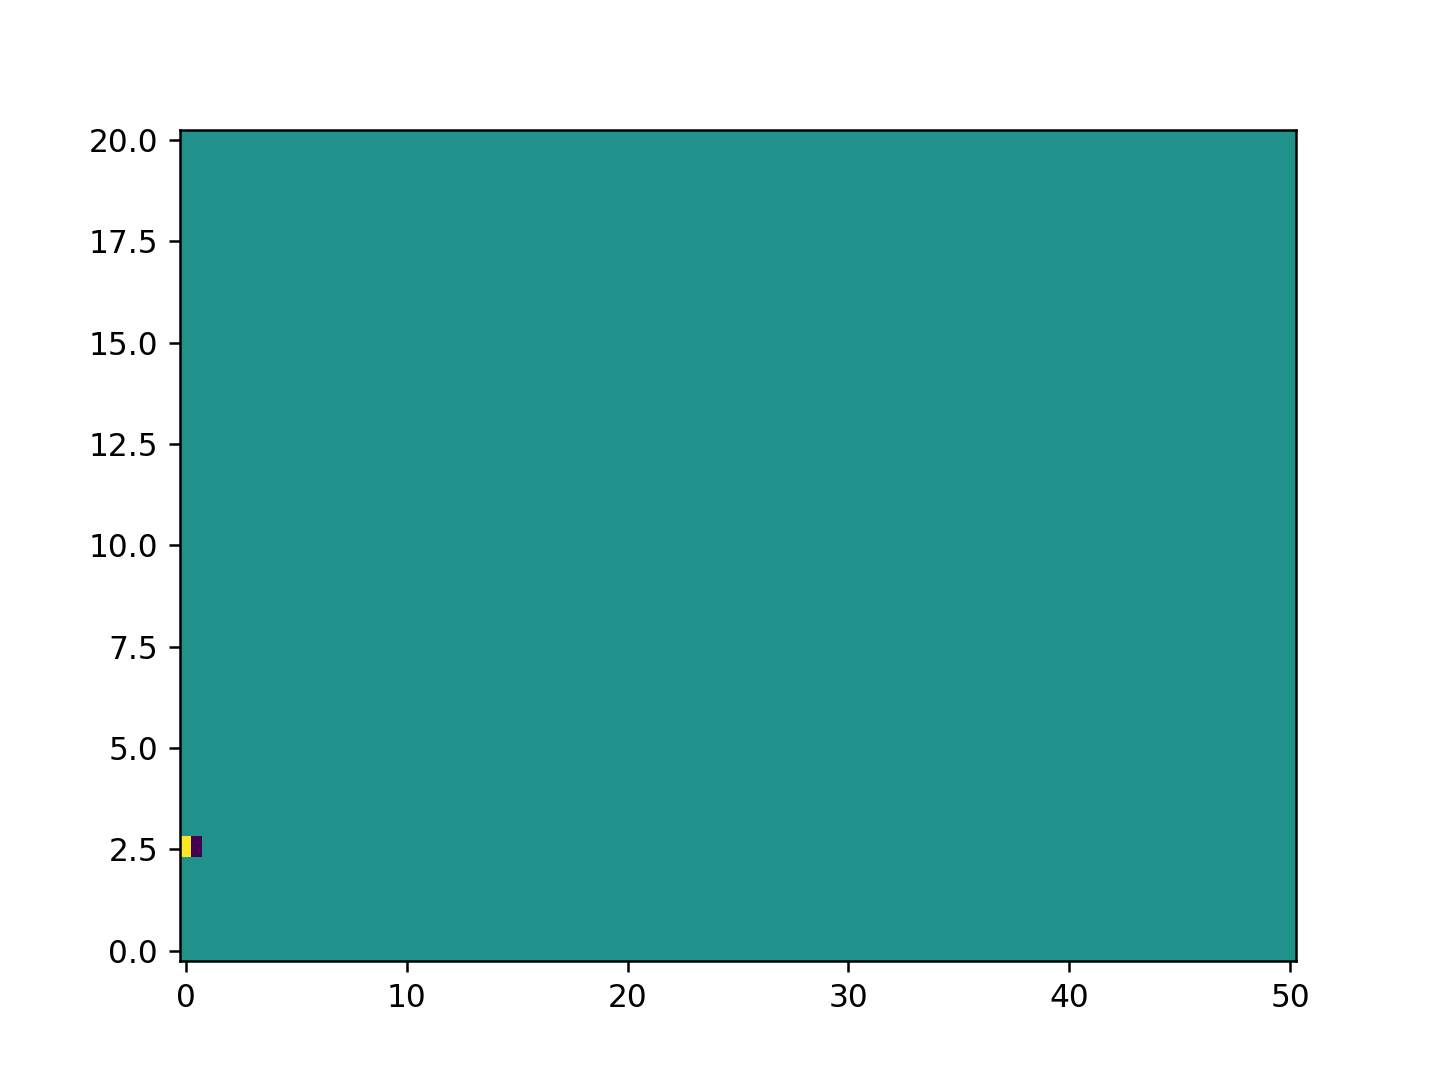

In [8]:
# Debugging hint: Show the coefficients belonging to a specific point.

plt.figure()
plt.pcolormesh(m.x, m.y, A[m.get_mem_pos(0, 5), :].reshape((m.nx, m.ny)).T, shading="auto")
plt.show()

Optional step: convert matrix A to a sparse matrix

In [9]:
#A = csc_matrix(A) # converts A to a sparse matrix

And now, let's solve the problem:

In [10]:
start = time()
phi = solve(A,b) # for normal solution
#phi = spsolve(A,b) # for sparse matrix
end = time()
print('Matrix inversion took', end-start, 'seconds to complete.')

Matrix inversion took 0.7355358600616455 seconds to complete.


__Hint:__ try and switch the datatypes of matrices A and b from numpy.array to scipy.sparse.csc_matrix; then, use solver scipy.sparse.linalg.spsolve. This means, matrices are archived as sparse. How does the computing time change?

## Postprocessing

In [11]:
# treatment for mesh before plotting
phi = phi.reshape((m.nx, m.ny))
phi = phi.transpose()

<IPython.core.display.Javascript object>


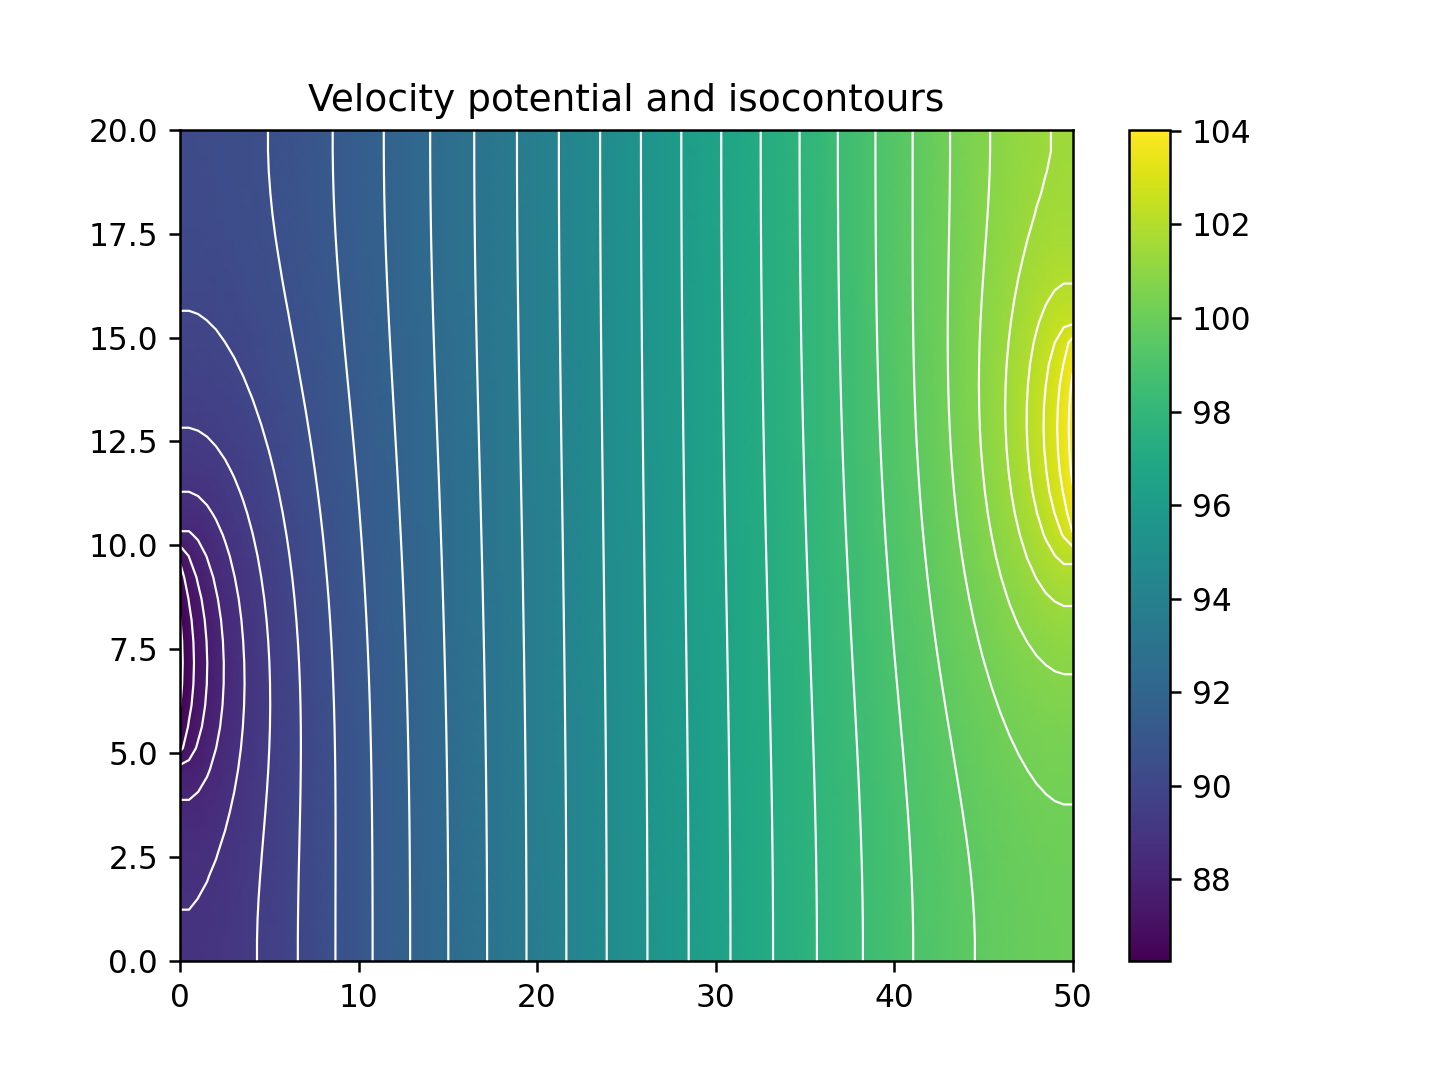

In [12]:
fig, ax = plt.subplots()
ax.set_title('Velocity potential and isocontours')
pos = ax.pcolormesh(m.x, m.y, phi, shading='gouraud')
fig.colorbar(pos)
ax.contour(m.x, m.y, phi, 30, colors='white', linewidths=.7)

In [13]:
print(phi.shape)
# calculate gradient
v,u = np.gradient(phi, m.dx, m.dy)

(40, 100)


<IPython.core.display.Javascript object>


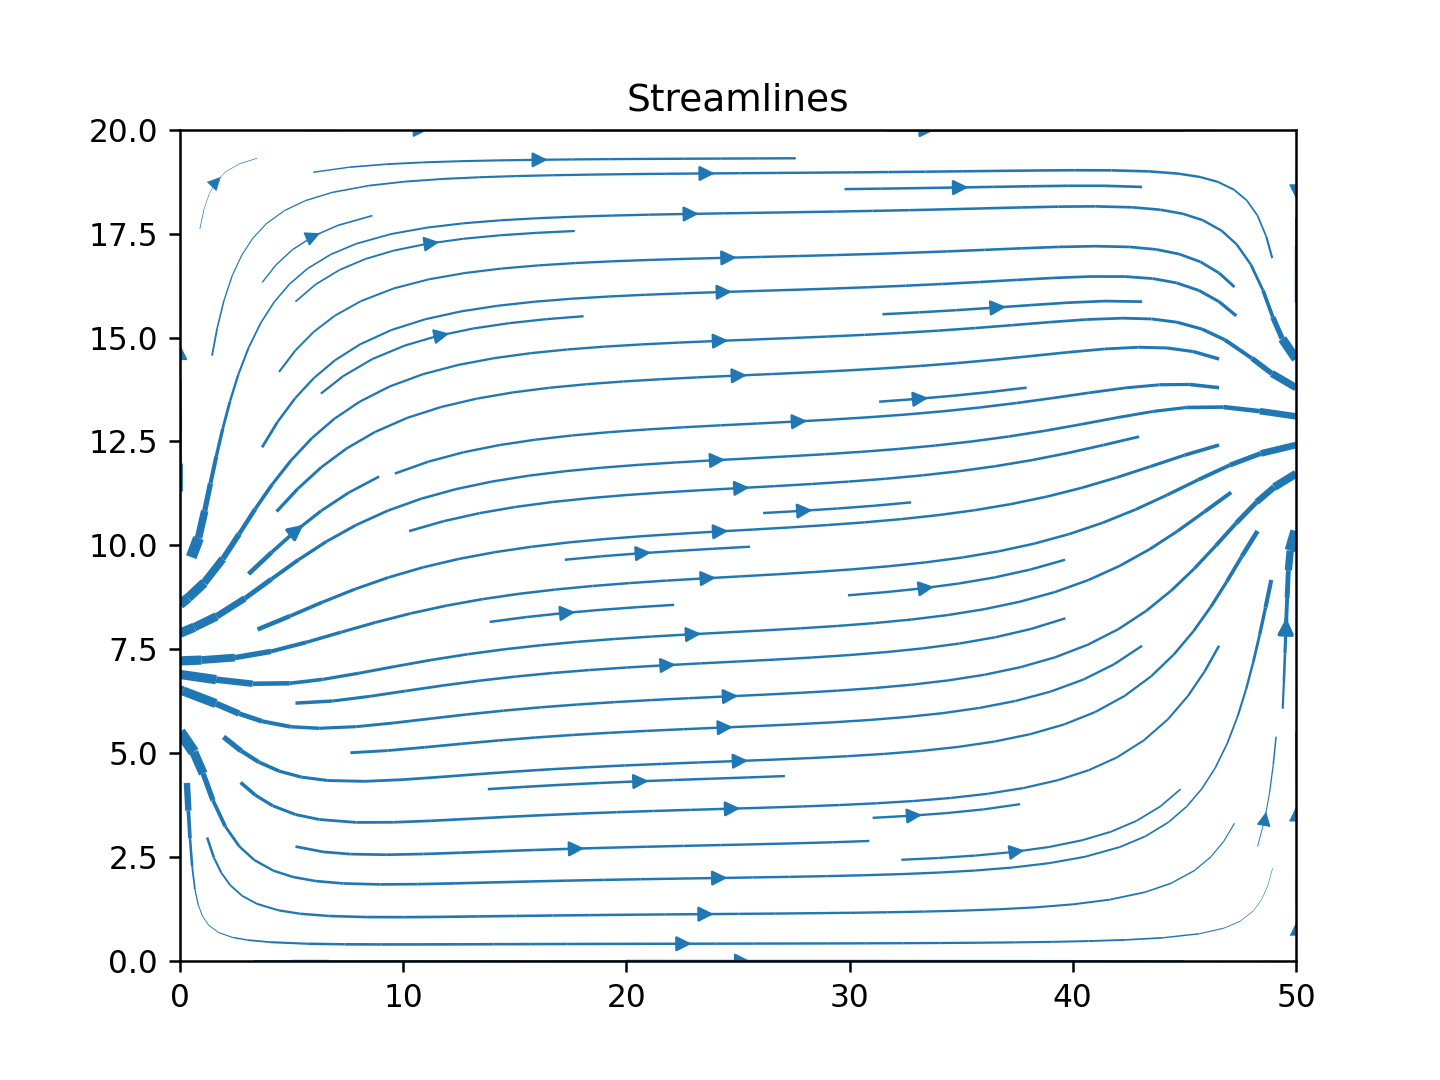

(0.0, 20.0)

In [15]:
fig, ax = plt.subplots()
ax.set_title('Streamlines')
ax.streamplot(m.x, m.y, u, v, linewidth=np.sqrt(u**2 + v**2)*3) # start_points = np.array([[25, i] for i in np.linspace(0, m.ly, 30)])
plt.xlim(0, m.lx)
plt.ylim(0, m.ly)

<IPython.core.display.Javascript object>


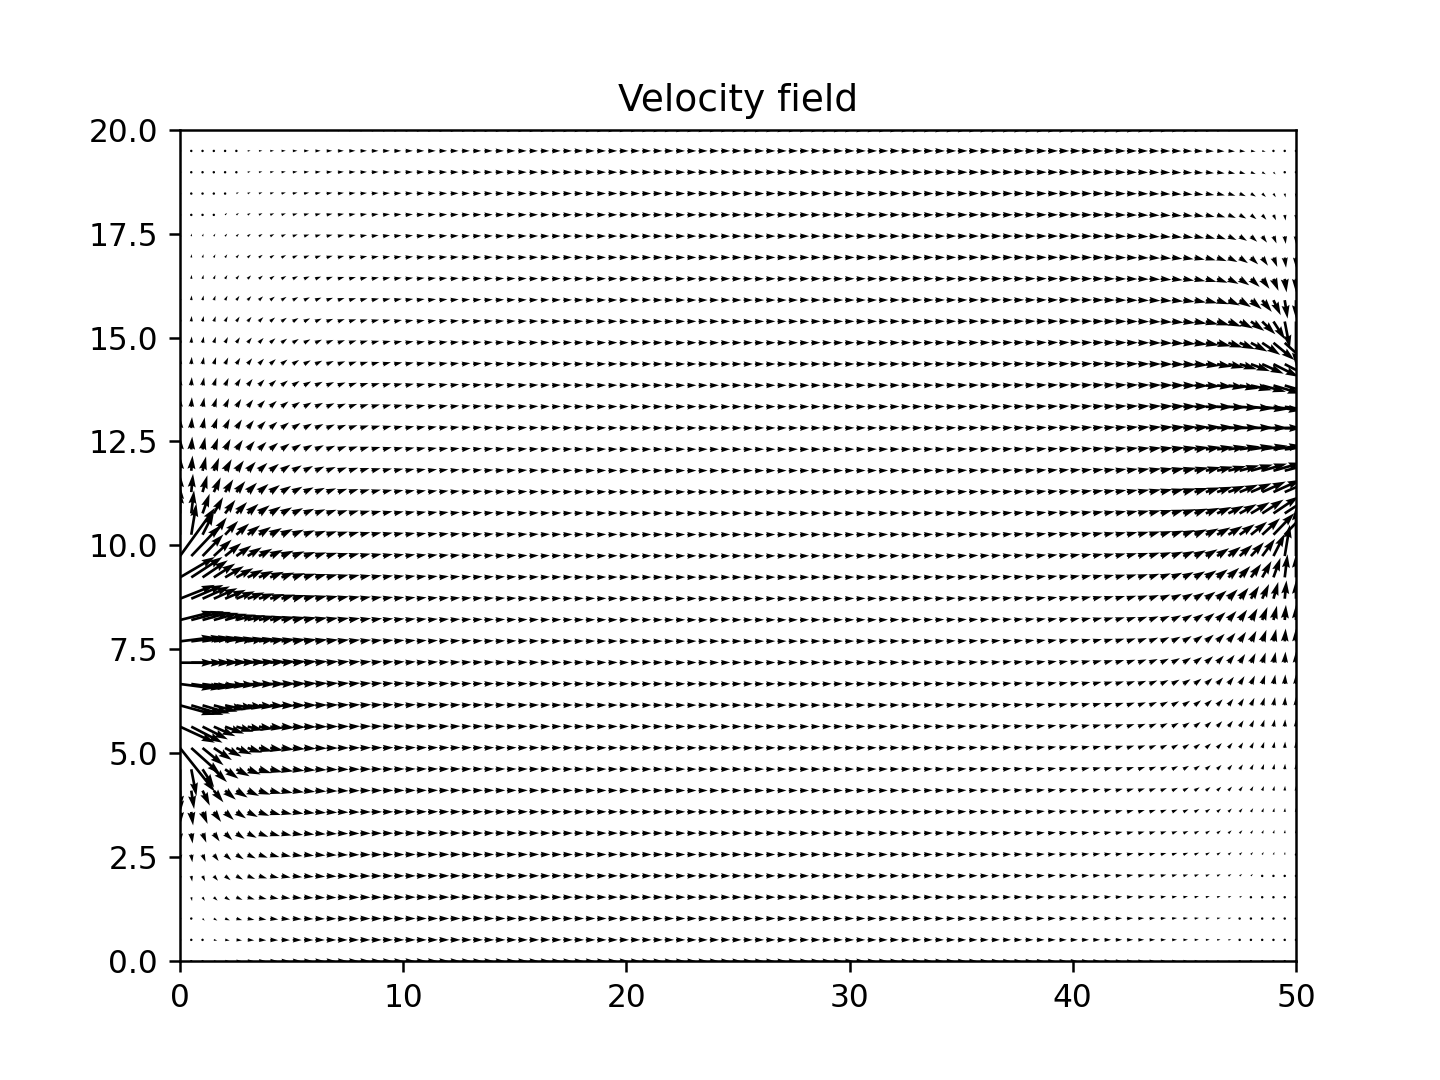

(0.0, 20.0)

In [16]:
fig, ax = plt.subplots()
ax.set_title('Velocity field')
ax.quiver(m.x, m.y, u, v)
plt.xlim(0, m.lx)
plt.ylim(0, m.ly)